In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1' # 사용하려는 GPU 번호
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import IPython.display as ipd
%matplotlib inline

# 3. 상수 설정

Standardizatino 과 min-max scaling 모두 적용해보았으나 아무것도 적용하지 않은 경우 점수가 더 높았습니다.

In [2]:
SCALE = False

# 4. 데이터 불러오기

In [3]:
trainset = pd.read_csv('train.csv')

In [4]:
# 결측치 확인
np.sum(trainset.isna())

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
number_of_rentals            0
dtype: int64

In [5]:
testset = pd.read_csv('test.csv')

In [6]:
# 결측치 확인
np.sum(testset.isna())

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
dtype: int64

In [7]:
# 최종 제출을 위한 dataframe 불러오기
submission = pd.read_csv('sample_submission.csv')

원본 dataframe 의 date_time 칼럼은 기계학습 알고리즘에 그대로 적용하기에 정보가 부족합니다. 그래서 정보를 상세하게 풀어서 추가해주었습니다. 
* week: 연도 별로 몇째 주 마다 이용자가 다를 수 있으므로 요일 정보를 추가해줍니다.
* weekday: 요일별로 따릉이 이용자가 다를 수 있으므로 요일 정보를 추가해줍니다.
* <b>추가 해볼 수 있는 것: 평일 / 주말 이용자가 다를 수 있으므로 평일과 주말에 대한 칼럼도 추가해주면 성능 향상에 도움이 될 듯 합니다.</b>

In [8]:
trainset['Temperature']= (trainset['low_temp']+trainset['high_temp'])/2
testset['Temperature']= (testset['low_temp']+testset['high_temp'])/2
trainset['Feeling'] = (5/9)*trainset['Temperature']-0.55*((100-trainset['humidity'])/100)*((5/9)*trainset['Temperature']-26)+32
testset['Feeling'] = (5/9)*testset['Temperature']-0.55*((100-testset['humidity'])/100)*((5/9)*testset['Temperature']-26)+32

In [9]:
def split_date(df):
    '''
    args
        df: 원본 데이터프레임
    return
        year, month, day, week, weekday 정보를 추가한 dataframe
    '''
    df['year'] = pd.to_datetime(df['date_time']).dt.year
    df['month'] = pd.to_datetime(df['date_time']).dt.month
    df['day'] = pd.to_datetime(df['date_time']).dt.day
    df['week'] = pd.to_datetime(df['date_time']).dt.week
    df['weekday'] = pd.to_datetime(df['date_time']).dt.weekday
    # df['quarter'] = pd.to_datetime(df['date_time']).dt.quarter # 데이터는 모두 동일 분기 데이터이므로 무의미
    
    return df.drop(columns=['date_time'])

In [10]:
# import seaborn as  sns
# import matplotlib.pyplot as plt
# sns.pairplot(trainset[["wind_direction","sky_condition","number_of_rentals","precipitation_form","wind_speed","humidity","low_temp","high_temp","Precipitation_Probability","year","month","day","weekday"]])
# # sns.pairplot(trainset[["wind_direction","sky_condition", "precipitation_form","wind_speed","humidity","low_temp","high_temp","Precipitation_Probability","number_of_rentals","year","month","day","weekday","number_of_rentals"]])
# plt.show()

In [11]:
traindf = split_date(trainset)
testdf = split_date(testset)

In [12]:
keys = traindf.drop(columns=['number_of_rentals']).keys()

In [13]:
traindf.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,Temperature,Feeling,year,month,day,week,weekday
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,16.800,43.625000,2018,4,1,13,6
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,15.906,43.684381,2018,4,2,14,0
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,12.814,41.727607,2018,4,3,14,1
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,10.340,40.880622,2018,4,4,14,2
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,8.148,39.622864,2018,4,5,14,3


In [14]:
testdf.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,Temperature,Feeling,year,month,day,week,weekday
0,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,16.2335,47.712140,2021,4,1,13,3
1,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,15.5000,45.735730,2021,4,2,13,4
2,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,12.6215,41.386989,2021,4,3,13,5
3,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,11.8090,42.485690,2021,4,4,13,6
4,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,12.9360,44.549069,2021,4,5,14,0


In [15]:
keydict = dict()
for i, k in enumerate(keys):
    keydict[i]=k

데이터 학습을 위해 입력값과 출력값을 분리해줍니다.

In [16]:
X = np.array(traindf.drop(columns=['number_of_rentals'])).astype(float)
y = np.array(traindf['number_of_rentals']).astype(float)
X_test = np.array(testdf).astype(float)

if SCALE:
    x_max = np.max(X, 0)
    y_max = np.max(y, 0)
    X /= x_max
    y /= y_max
    X_test /= x_max

# 5. 유틸리티

In [17]:
def nmae(true, pred):
    return np.mean(np.abs(true-pred)/true)

성능 확인을 위해서 몬테카를로 교차검증을 사용합니다([링크](https://en.wikipedia.org/wiki/Cross-validation_(statistics)의 섹션 Repeated random sub-sampling validation 참고).

In [18]:
def cv(model, X=X, y=y, cnt=100, test_size=.5):
    score = list()
    seeds = np.random.choice(np.arange(1e5), size=cnt, replace=False)
    for seed in seeds:
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        if SCALE:
            y_pred *= y_max
            y_valid *= y_max
        score.append(nmae(y_valid, y_pred))
    return np.mean(score)

# 6. Feature selection

제거 법을 이용해서 feature selection 을 해봅니다.

In [19]:
def select_features(X, cols):
    _X = list()
    for c in cols:
        _X.append(np.expand_dims(X[:, c],-1))
    return np.concatenate(_X, axis=1)

In [20]:
keydict

{0: 'wind_direction',
 1: 'sky_condition',
 2: 'precipitation_form',
 3: 'wind_speed',
 4: 'humidity',
 5: 'low_temp',
 6: 'high_temp',
 7: 'Precipitation_Probability',
 8: 'Temperature',
 9: 'Feeling',
 10: 'year',
 11: 'month',
 12: 'day',
 13: 'week',
 14: 'weekday'}

다양한 모델 확인 결과 XGBRegressor 가 가장 좋아서 이걸 선택했습니다.

In [21]:
from xgboost import XGBRegressor as Model

In [22]:
min_loss = 1e10
min_cols = None

for i in np.arange(start=0, stop=len(keys)):
#     model = Model(tree_method='gpu_hist')
#     model = Model(silent = 1)
    model = Model(eta = 0.1)
    cols = np.arange(len(keys))
    cols = np.delete(cols, i)
    _X = select_features(X, cols)
    loss = cv(model, _X, y, cnt=30)
    if min_loss > loss:
        min_loss = loss
        min_cols = f"{keydict.get(i)}"
    print(f"{keydict.get(i)}, {loss:.4f} (min {min_loss:.4f})")

wind_direction, 0.2538 (min 0.2538)
sky_condition, 0.2610 (min 0.2538)
precipitation_form, 0.2412 (min 0.2412)
wind_speed, 0.2485 (min 0.2412)
humidity, 0.2429 (min 0.2412)
low_temp, 0.2298 (min 0.2298)
high_temp, 0.2459 (min 0.2298)
Precipitation_Probability, 0.2489 (min 0.2298)
Temperature, 0.2412 (min 0.2298)
Feeling, 0.2441 (min 0.2298)
year, 0.4757 (min 0.2298)
month, 0.2367 (min 0.2298)
day, 0.2431 (min 0.2298)
week, 0.2460 (min 0.2298)
weekday, 0.2501 (min 0.2298)


In [23]:
for i in np.arange(start=0, stop=len(keys)-1):
    for j in np.arange(start=i+1, stop=len(keys)):
#         model = Model(tree_method='gpu_hist')
        model = Model(eta = 0.1)
        cols = np.arange(len(keys))
        cols = np.delete(cols, [i,j])
        _X = select_features(X, cols)
        loss = cv(model, _X, y, cnt=30)
        if min_loss > loss:
            min_loss = loss
            min_cols = f"{keydict.get(i)}, {keydict.get(j)}"
        print(f"{keydict.get(i)}, {keydict.get(j)}, {loss:.4f} (min {min_loss:.4f})")

wind_direction, sky_condition, 0.2437 (min 0.2298)
wind_direction, precipitation_form, 0.2540 (min 0.2298)
wind_direction, wind_speed, 0.2246 (min 0.2246)
wind_direction, humidity, 0.2560 (min 0.2246)
wind_direction, low_temp, 0.2431 (min 0.2246)
wind_direction, high_temp, 0.2510 (min 0.2246)
wind_direction, Precipitation_Probability, 0.2551 (min 0.2246)
wind_direction, Temperature, 0.2548 (min 0.2246)
wind_direction, Feeling, 0.2446 (min 0.2246)
wind_direction, year, 0.4751 (min 0.2246)
wind_direction, month, 0.2624 (min 0.2246)
wind_direction, day, 0.2430 (min 0.2246)
wind_direction, week, 0.2458 (min 0.2246)
wind_direction, weekday, 0.2614 (min 0.2246)
sky_condition, precipitation_form, 0.2451 (min 0.2246)
sky_condition, wind_speed, 0.2515 (min 0.2246)
sky_condition, humidity, 0.2260 (min 0.2246)
sky_condition, low_temp, 0.2458 (min 0.2246)
sky_condition, high_temp, 0.2471 (min 0.2246)
sky_condition, Precipitation_Probability, 0.2646 (min 0.2246)
sky_condition, Temperature, 0.2469 (

0: 'wind_direction' 과  7: 'Precipitation_Probability' 가 없을 때 성능이 좋을듯 합니다. 풍향은 자전거 이용에 영향을 미치는 변수가 아닐 듯 합니다. 한편, 강수확률(Precipitation_Probability)은 관측치가 아니라 기상청 예측치라면, 예측 오류가 우리가 만드는 최종 모델의 오류를 더 커지게 할 수 있기 때문에 빼는 것이 좋겠습니다.

In [24]:
trainset.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,Temperature,Feeling,year,month,day,week,weekday
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,16.800,43.625000,2018,4,1,13,6
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,15.906,43.684381,2018,4,2,14,0
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,12.814,41.727607,2018,4,3,14,1
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,10.340,40.880622,2018,4,4,14,2
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,8.148,39.622864,2018,4,5,14,3


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

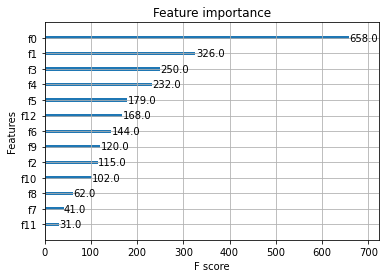

In [25]:
from xgboost import plot_importance

plot_importance(model)

## min_loss = 0.2197


# 7. 모델 학습

In [26]:
model = Model(eta = 0.1)

cols = np.arange(len(keys))
cols = np.delete(cols, [0,7]) # 풍향, 강수확률 제거
_X = select_features(X, cols)

model.fit(_X, y)

_X_test = select_features(X_test, cols)
y_pred = model.predict(_X_test)
if SCALE:
    y_pred *= y_max
y_pred = y_pred.astype(int)

# plt.scatter(np.arange(len(y_pred)), y_pred, s=.5)
# plt.show()

In [27]:
submission['number_of_rentals'] = y_pred

In [28]:
submission.to_csv('find_origin-0.1-feeling-hyperparam-copy_xgboost_submission.csv', index=False)

# score =0.4956833938	( eta = 0.1)
# score =0.4987798086	(eta = 0.05)D